In [15]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
import pytorch_lightning as pl
import os
from pytorch_lightning.utilities.parsing import AttributeDict
from pytorch_lightning.loggers import TensorBoardLogger

In [16]:
# import matplotlib.pyplot as plt
# import kornia

In [17]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [18]:
from lieposenet.utils.universal_factory import UniversalFactory
from lieposenet.models.pose_net import PoseNet
from lieposenet.criterions.pose_net_criterion import PoseNetCriterion
from lieposenet.criterions.se3_criterion import SE3Criterion
from lieposenet.data import SevenScenesDataModule

factory = UniversalFactory([PoseNet, PoseNetCriterion, SE3Criterion])

In [19]:
from clearml import Task, Logger

In [22]:
task = Task.init(project_name="lie-pose-net", task_name="LiePoseNet on local machine")

ClearML Task: created new task id=d46f34f2fcf941be9ce4aca0a23a0f07
ClearML results page: https://app.community.clear.ml/projects/04b664f021694b21aadb7a6f50ab46f1/experiments/d46f34f2fcf941be9ce4aca0a23a0f07/output/log
2021-09-01 17:18:03,027 - clearml.Task - WARNING - ### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


# Load datamodule

In [6]:
data_module_params = {
    "batch_size": 64,
    "use_test": True,
    "num_workers": 4,
    "image_size": 256,
    "scene": "fire",
    "data_path": "/media/mikhail/Data3T/7scenes"
}
task.connect(data_module_params)
scene = data_module_params["scene"]
data_module = SevenScenesDataModule(**data_module_params)

/usr/local/lib/python3.9/dist-packages/IPython/core/inputsplitter.py:21: DeprecationWarning:

IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`



[ToyDataModule] - train subset size 2000
[ToyDataModule] - validation dataset size 2000


# Model

In [7]:
model_params =  AttributeDict(**{
    "name": "PoseNet",
    "feature_extractor": AttributeDict(
        pretrained=True
    ),
    "criterion": {
        "name": "SE3Criterion",
        "rotation_koef": -3.0,
        "translation_koef": -3.0,
    },
    "feature_dimension": 2048,
    "drop_rate": 0,
    "optimizer": AttributeDict(
        betas="0.9 0.999",
        lr=0.0001,
        weight_decay=0.0005,
    ),
    "scheduler": {
        "step_size": 20,
        "gamma": 0.5,
    },
    "bias": True,
    "activation": "tanh",
    "pretrained": True
})
task.connect(model_params)
model = factory.make_from_parameters(model_params)

/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:135: DeprecationWarning:

'jinja2.Markup' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.Markup' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:135: DeprecationWarning:

'jinja2.Markup' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.Markup' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/

2021-09-01 16:02:05,881 - clearml.model - INFO - Selected model id: a22c91c76a0f4ef791b13c6d45497aa2


# Train

In [8]:
logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "lieposenet")
# logger_path = 'lightning_logs'
trainer_params = {
    "max_epochs": 1,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
task.connect(trainer_params)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_params["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name=scene),
    callbacks=[model_checkpoint],
    **trainer_params
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type         | Params
---------------------------------------------------
0 | criterion         | SE3Criterion | 6     
1 | feature_extractor | ResNet       | 22.3 M
2 | final_fc          | Linear       | 57.4 K
---------------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.571    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'median_position_error': 0.4908968210220337,
 'median_rotation_error': 16.67397117614746,
 'position_error': 0.5024413466453552,
 'rotation_error': 20.48438262939453,
 'test_loss': -4.1197333335876465}
--------------------------------------------------------------------------------


[{'test_loss': -4.1197333335876465,
  'position_error': 0.5024413466453552,
  'rotation_error': 20.48438262939453,
  'median_position_error': 0.4908968210220337,
  'median_rotation_error': 16.67397117614746}]

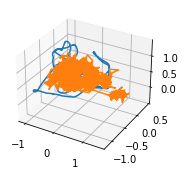

In [10]:
trainer.test(model, data_module.test_dataloader())

In [11]:
truth_position = model._data_saver["truth_position"]
predicted_position = model._data_saver["predicted_position"]

In [12]:
Logger.current_logger().report_scatter3d(title="trajectory", series="truth_positions", iteration=1, 
                                         scatter=truth_position,
     xaxis="x", yaxis="y", zaxis="z", mode="lines")
Logger.current_logger().report_scatter3d(title="trajectory", series="predicted_position", iteration=1, 
                                         scatter=predicted_position,
     xaxis="x", yaxis="y", zaxis="z", mode="lines")

In [13]:
task.close()

2021-09-01 16:02:47,888 - clearml.Task - INFO - Waiting to finish uploads


/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:135: DeprecationWarning:

'jinja2.Markup' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.Markup' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:135: DeprecationWarning:

'jinja2.Markup' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.Markup' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/

2021-09-01 16:02:53,204 - clearml.Task - INFO - Finished uploading
